<a href="https://colab.research.google.com/github/AatishKumar649/20th-June-Sc-Qc/blob/main/20th_June_Sc_Qc_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
# Turns off Scanpy messages/logs. 0 means “no output”, so it won’t flood your screen with unnecessary info.
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
    # Sets how figures/plots will look:
    # dpi=80 → image clarity (dots per inch).
    # facecolor="white" → background color of plots.
    # frameon=False → no border/frame around plots.
)

1. Imports NumPy, which is used for numerical operations (like working with arrays, calculating means, etc.).
2. Imports Scanpy, the main library used for analyzing single-cell RNA-seq data in Python.
3. Imports Seaborn, a data visualization library based on matplotlib, used for making pretty plots.
4. Imports a function that calculates Median Absolute Deviation (MAD) — a statistic used for detecting outliers or data variability.


# **Loading of Dataset**

In [4]:
adata = sc.read_10x_h5(
    filename="filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata

# This loads the single-cell dataset from a file in 10X Genomics HDF5 format (.h5).
# If the file "filtered_feature_bc_matrix.h5" is not found locally, it will automatically download it from the provided backup_url (hosted on Figshare).
# This file contains:
# The gene expression matrix
# Gene and barcode (cell) info
# It returns an AnnData object and stores it in the variable adata.

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

💡 What is adata?
adata is a special object type in Scanpy called AnnData — short for Annotated Data.

It’s like a smart container that holds your full single-cell dataset:

.X → the actual gene expression values (matrix)
.obs → info about cells (like cell IDs, QC metrics, clusters)
.var → info about genes (gene names, etc.)
.uns, .obsm, .varm, etc. → extra data for analysis and plots

**Uniqueness of Data**
When you load the dataset with Scanpy, it may show a warning message like:

⚠️ Warning: Not all variable names are unique.
🤔 What does this mean?
In the AnnData object (adata), each gene has a name (these are stored in adata.var_names).
Sometimes, the same gene name appears more than once in the dataset.
For example: two genes might both be named "MT-CO1".
This is a problem because:

Many functions in Scanpy and Python expect every gene name to be unique.
If gene names are duplicated, some steps (like plotting or filtering) can behave unexpectedly or cause errors.

In [6]:
adata.var_names_make_unique()
adata
# This function automatically fixes the duplicate gene names.
# If a gene name appears multiple times, it will add numbers to make them unique.

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

n_obs = number of observations (rows) = 16,934 barcodes ;
n_vars = number of variables (columns) = 36,601 genes (transcripts) ;
So this matrix tells us how much each gene was expressed in each barcode (potential cell).

.var gives info about the genes (variables).
It contains:

gene_ids → official gene IDs (e.g., Ensembl IDs like ENSG00000141510) ;
feature_types → type of data (e.g., "Gene Expression" or "Antibody Capture") ;
genome → reference genome used (e.g., "GRCh38")

# **Filtering Low Quality Cells**

The first step in cleaning up your single-cell data is to get rid of cells that look suspicious or unhealthy — these are called low-quality cells.

🧪 Why are they considered low quality?
Some cells in the data may:

Express very few genes
Have a very small number of total reads (low count depth);
Have a high percentage of mitochondrial gene expression ;
🧬 Mitochondrial genes are usually a small part of total RNA. But if a lot of the RNA in a cell is from mitochondria, it often means:

The cell is stressed, damaged, or dying.
The cell’s membrane might be broken, and its RNA is leaking out.
These bad-quality cells can mess up the results of your analysis — so we want to remove them before we go further.

 How do we identify low-quality cells?
We use three key metrics (QC covariates) to filter out bad cells:

**Number of counts per barcode (total reads or count depth)**
→ Tells us how much total RNA was captured for each cell.   \\
**Number of genes per barcode**
→ Tells us how many different genes are being expressed in each cell.
→ A very low number might mean the cell is dead or the RNA was not captured properly.   \\
**Percentage of mitochondrial gene counts per cell**
→ High values usually mean the cell is dying.

When we filter cells based on the **3 QC metrics (number of genes, count depth, and mitochondrial gene percentage)**, we usually set cutoff values to decide which cells to keep or remove.

⚠️ Why?
Because a cell might look bad based on one metric, but still be a healthy and real cell depending on the context.

Let’s go through some examples:

🧬 **High mitochondrial % ≠ always bad**

Yes, a high percentage of mitochondrial reads can mean a dying cell…
But, some healthy cells (like those involved in energy production) naturally express more mitochondrial genes.
Example: muscle or some immune cells during active respiration
                                            📉 **Low gene or count numbers ≠ always bad**

Some cells naturally express fewer genes or have lower total RNA.
Example: quiescent cells (resting phase)
Example: small or less active cells
Removing these might throw away rare but important cell types.

**In other words:**
✅ Clean your data,
🚫 but don’t over-clean it.

**Type of QC Based on data**

1.  **Manual QC:**
When you're working with small datasets, you can often just look at the plots (like histograms or violin plots of QC metrics) and manually decide where to set your thresholds.
You might say: "Cells with less than 200 genes look bad, I’ll remove them."

2.  **Automated QC Using MAD (Median Absolute Deviation):**
MAD is a robust statistic — it’s like standard deviation, but better for noisy, real-world data.
It measures how spread out your data is, but without getting affected too much by extreme outliers.
Formula (don't worry, we won’t go deep into math):

If you have a QC metric like “number of genes per cell”, then:

Compute the median of all values.
For each value, get the absolute difference from the median.
Then take the median of those differences → that’s the MAD.
 **MAD=median(∣x i −median(x)∣)**

**How to identify outliers?**
If a cell is more than 5 MADs away from the median (either too high or too low), it's considered an outlier.
This method is relatively gentle — it doesn’t aggressively remove cells, so it’s a safe first filter.

 **Special Gene Types:**
We care about some specific groups of genes:

**Mitochondrial genes**
In humans → usually start with "MT-"
In mice → usually start with "mt-"
**Ribosomal genes** → typically start with "RPS" or "RPL"
**Hemoglobin genes** → often start with "HB" (used in blood-related samples).
These help identify low-quality or special types of cells.

In [10]:
#  defining specific gene groups before using sc.pp.calculate_qc_metrics()
# so that Scanpy can calculate the percentage of reads coming from mitochondrial, ribosomal, and hemoglobin genes for each cell.


# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ✅ Why we need it:
# Scanpy will use this "mt" column to calculate the fraction of mitochondrial reads per cell.
# This is a key QC metric, because high mitochondrial RNA often means dying cells.

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# ✅ Why we need it:
# Ribosomal genes are usually highly expressed in most cells.
# Tracking ribosomal content can help spot overactive cells or technical biases.

# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
# ✅ Why we need it:
# In blood or bone marrow datasets, hemoglobin genes can dominate the reads, especially if there’s red blood cell contamination.
# So it’s useful to measure and possibly filter based on hemoglobin gene expression.

**calculate the respective QC metrics with scanpy.**

In [9]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=False, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

qc_vars=["mt", "ribo", "hb"]

You're telling Scanpy to calculate percentages of counts coming from:
"mt" → mitochondrial genes //
"ribo" → ribosomal genes //
"hb" → hemoglobin genes

**inplace=True**

This tells Scanpy to add the new QC metrics directly into adata.obs and adata.var.
If you set it to False, it would return a separate object instead.

**percent_top=[20]**

This calculates the percentage of counts coming from the top 20 most highly expressed genes in each cell.
Useful for checking if certain genes are dominating the RNA — which may indicate a technical artifact.

log1p=True

It adds a new matrix to your AnnData object: adata.obs["log1p_total_counts"]
This is the log-transformed total counts, using the formula:
**log(1+total counts)**
This transformation helps in visualizations (like scatterplots or PCA) because count data is often very skewed.

**Observation after applying QC metrices**
1. **n_genes_by_counts**
This is the number of genes that have non-zero expression (positive counts) in each cell.
Cells with very few expressed genes might be dead, empty droplets, or low-quality.
You’ll use this to help filter out poor-quality cells.
2. **total_counts**
This is the total number of RNA molecules (UMI counts) captured from each cell — sometimes called the library size.
Cells with very low total counts may have been damaged or poorly sequenced.
Very high total counts might indicate doublets (two cells captured together).
3. **pct_counts_mt**
This is the percentage of total RNA in a cell that comes from mitochondrial genes.
High mitochondrial percentage usually indicates that the cell is dying or stressed.
You can use this to flag and remove low-quality cells.

**Visualizing using Voilin Plots**

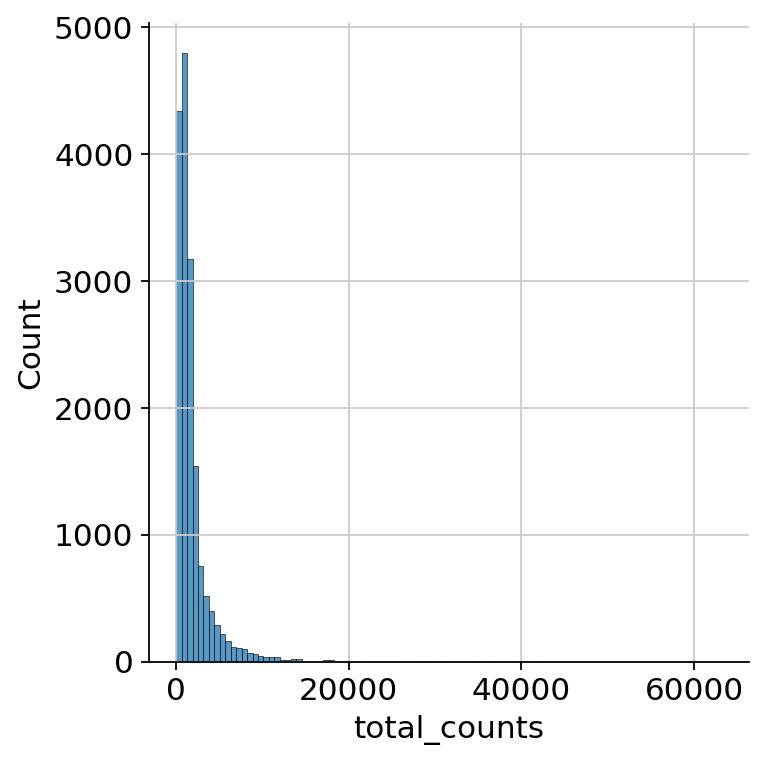

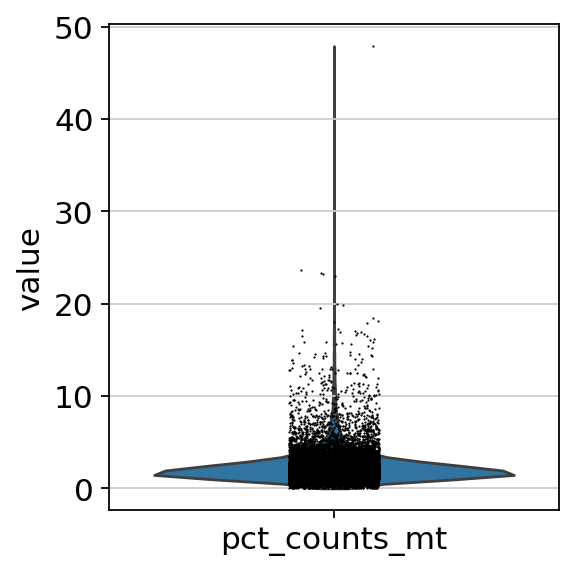

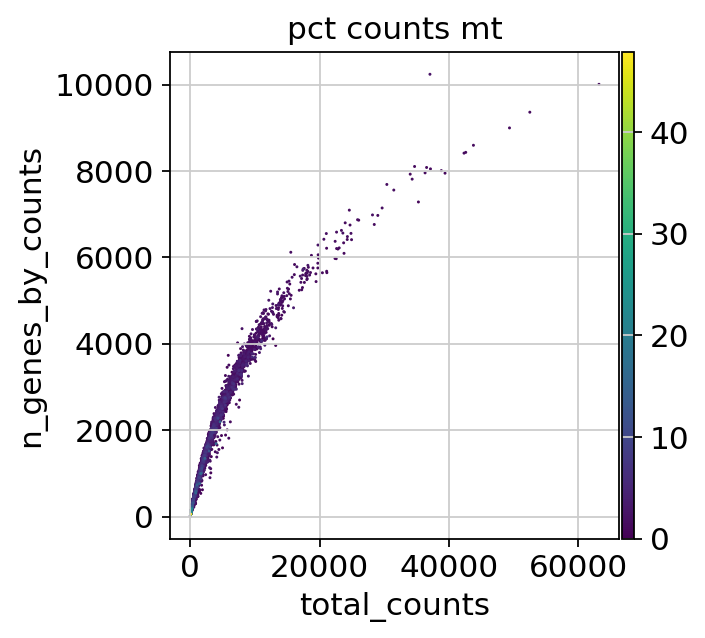

In [15]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Plot 1: Histogram of total_counts (library size per cell)

What it shows:
This plot shows how many cells have a given number of total RNA molecules captured (UMIs).
What to look for:
Left tail (very low counts) → cells that might be empty droplets, dead, or low-quality
Right tail (very high counts) → potential doublets (two cells captured as one)
✅ Example Insight:

If you see a lot of cells with very low total_counts, you might want to set a minimum threshold to filter them out.

Plot 2: Violin plot of pct_counts_mt (mitochondrial content)

What it shows:
For each cell, it shows the percentage of RNA that comes from mitochondrial genes.
Violin plots show distribution + density — wider parts mean more cells have that value.
What to look for:
Cells with very high mitochondrial content (e.g., > 10–15%) might be dying or damaged
A long upper tail is common and usually flagged for filtering
✅ Example Insight:

If many cells have >20% mitochondrial RNA, you might want to filter those out.

 Plot 3: Scatterplot of total_counts vs n_genes_by_counts, colored by pct_counts_mt

What it shows:
Each dot = one cell
X-axis: total RNA (total_counts)
Y-axis: number of genes expressed (n_genes_by_counts)
Color = mitochondrial percentage (pct_counts_mt)
What to look for:
Healthy cells: moderate total counts + high gene counts + low mitochondrial content (blue dots)
Bad cells: low total counts + low gene counts + high mitochondrial content (red/orange dots)
Doublets? High total counts + high gene counts
✅ Example Insight:

You’ll likely see a cluster of good cells in the middle, and a “tail” of low-quality cells in the lower-left (low total counts & genes, often reddish due to high mito%).

**Choosing threshholds and applying filters**
1. total_counts (Library Size)
Low total counts → likely empty droplets or broken cells
High total counts → possibly doublets (two cells captured as one).
Adjust based on your data’s distribution. 500–25,000 is a good starting range for 10X datasets.

2. n_genes_by_counts
Low number of genes → dead/empty cells
Extremely high number → could indicate doublets

3. pct_counts_mt (Mitochondrial %)
High mito % usually means dying or stressed cells
You can be stricter (e.g., <10%) if you're working with fragile or sensitive samples.

In [18]:
# Filter based on total UMI counts
adata = adata[adata.obs['total_counts'] > 500, :]
adata = adata[adata.obs['total_counts'] < 25000, :]

# Filter based on number of genes
adata = adata[adata.obs['n_genes_by_counts'] > 200, :]
adata = adata[adata.obs['n_genes_by_counts'] < 6000, :]

# Filter based on mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < 10, :]



In [19]:
print(f"Number of cells after filtering: {adata.n_obs}")


Number of cells after filtering: 13988


**Visualizing after Filteration**

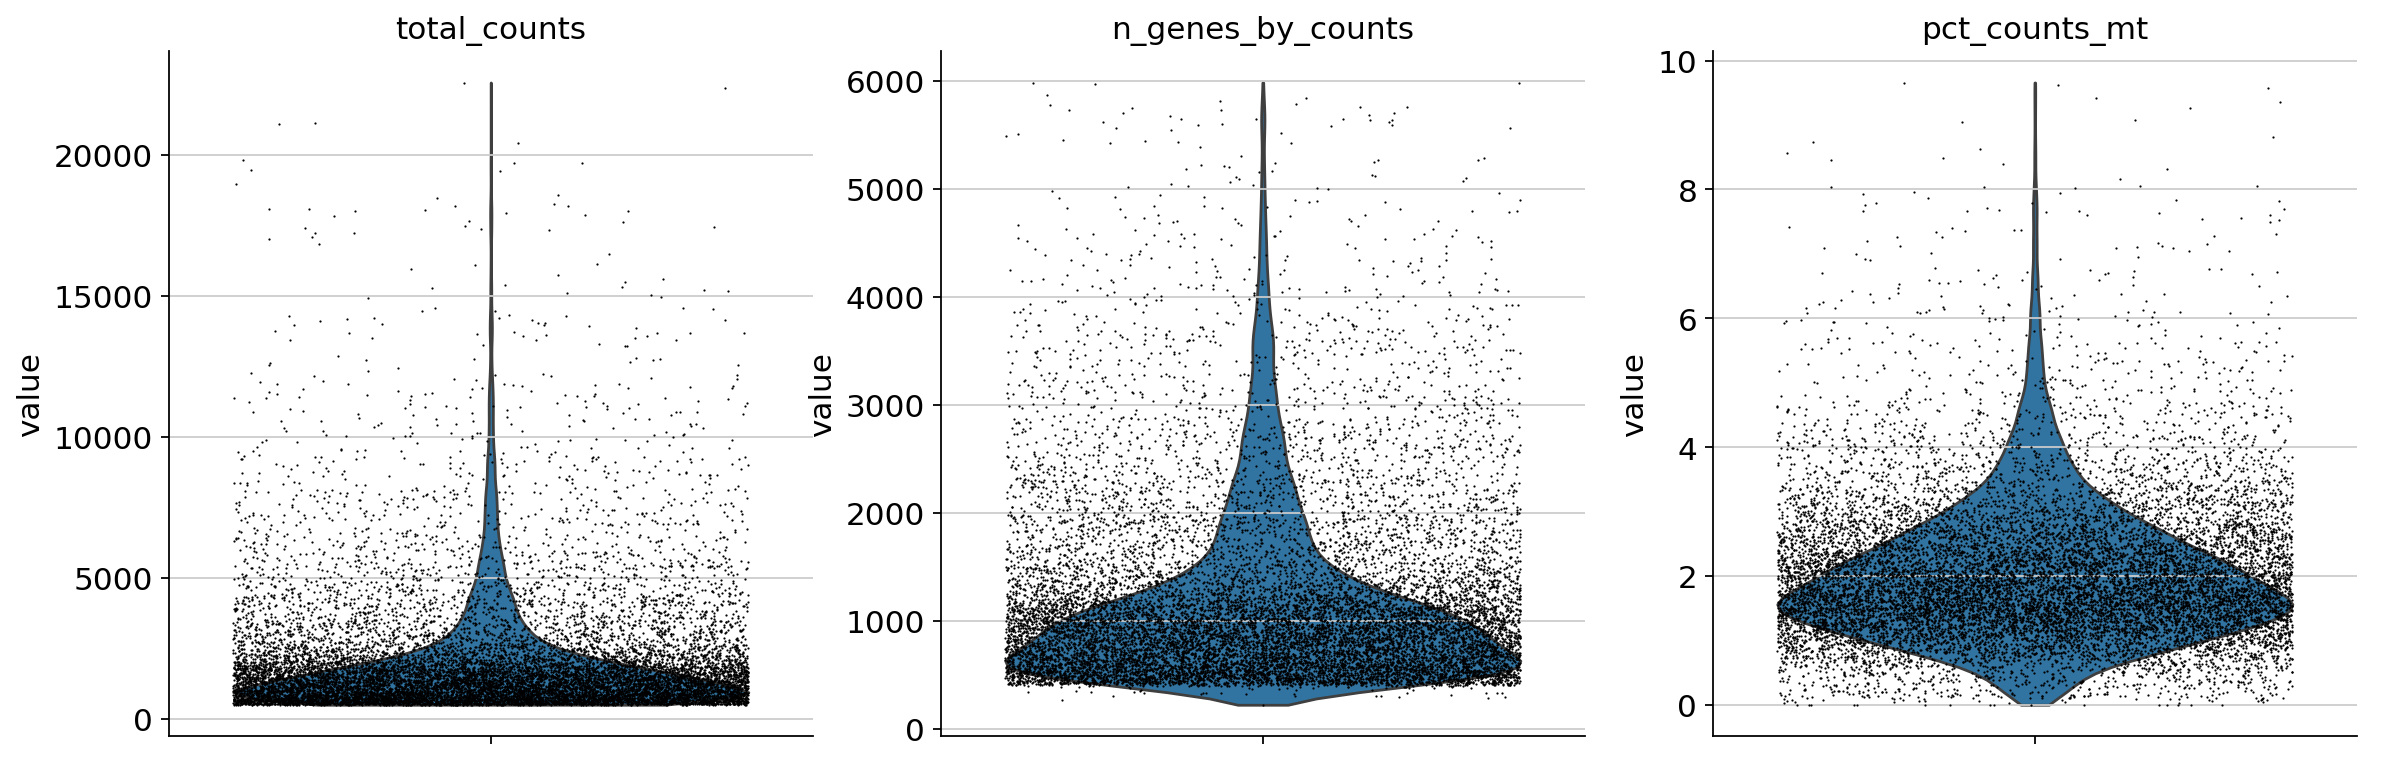

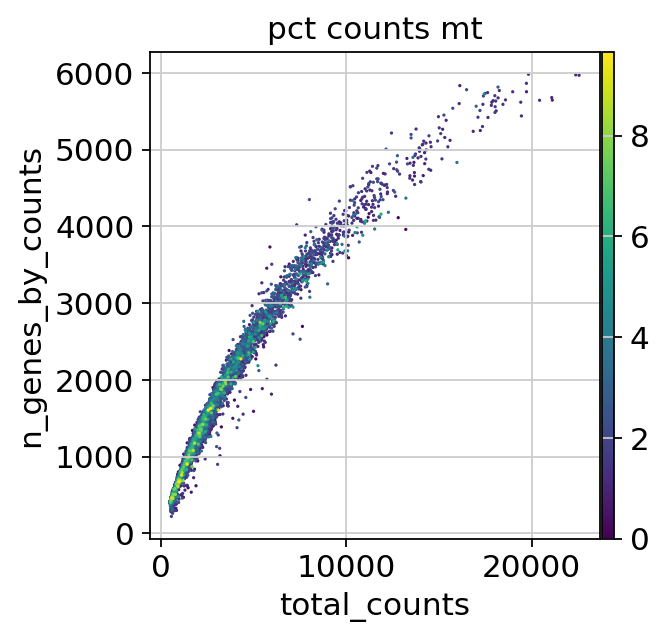

In [20]:
sc.pl.violin(adata, ["total_counts", "n_genes_by_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


**MAD based filtering **

What Is the Rule?

We flag a cell as an outlier (i.e., low quality) if its value is > 5 MADs away from the median.
This works in both directions:

Too low total counts or gene counts
Too high mitochondrial percentage


In [21]:
import numpy as np
from scipy.stats import median_abs_deviation

# Define a helper function to detect outliers using MAD
def mad_based_filtering(series, threshold=5, direction="both"):
    median = np.median(series)
    mad = median_abs_deviation(series)
    if direction == "lower":
        return series > (median - threshold * mad)
    elif direction == "upper":
        return series < (median + threshold * mad)
    else:  # both directions
        return (series > (median - threshold * mad)) & (series < (median + threshold * mad))


In [22]:
# Apply filters
filter_total_counts = mad_based_filtering(adata.obs["total_counts"], threshold=5, direction="both")
filter_n_genes = mad_based_filtering(adata.obs["n_genes_by_counts"], threshold=5, direction="both")
filter_mito = mad_based_filtering(adata.obs["pct_counts_mt"], threshold=5, direction="upper")

# Combine all filters
combined_filter = filter_total_counts & filter_n_genes & filter_mito

# Subset the AnnData object
adata = adata[combined_filter, :]


In [23]:
print(f"Remaining cells: {adata.n_obs}")


Remaining cells: 12354


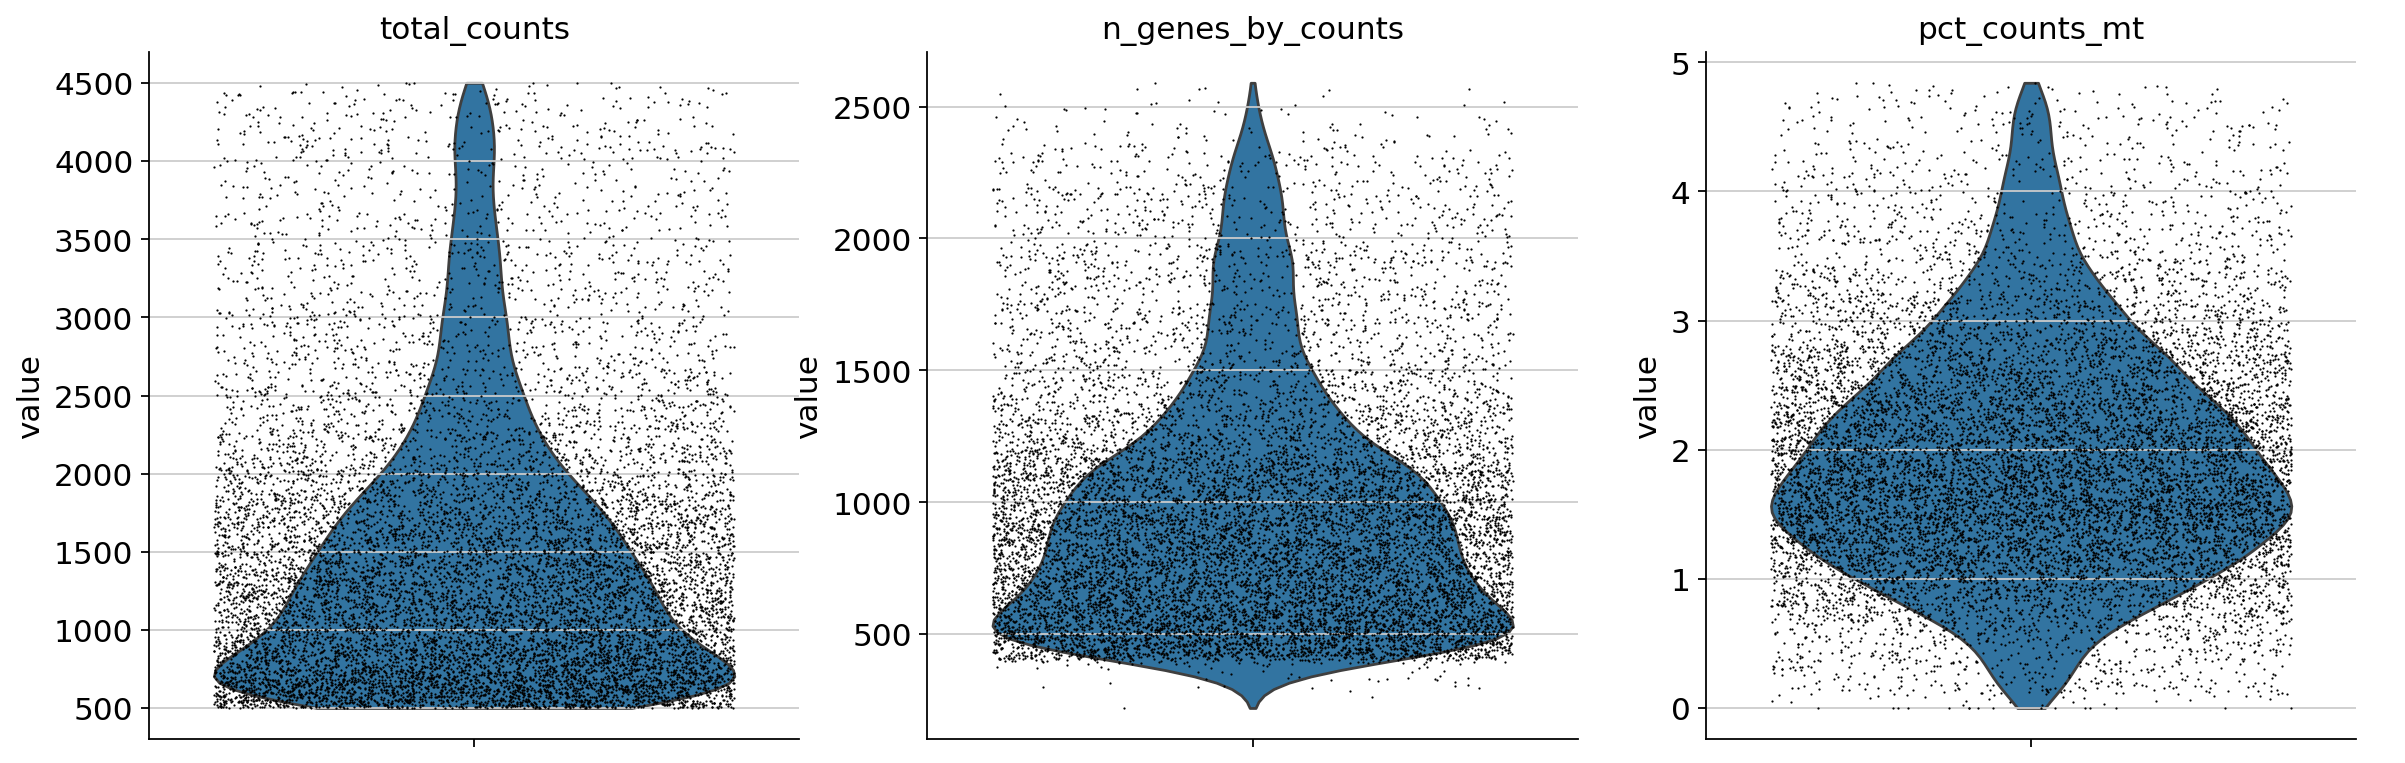

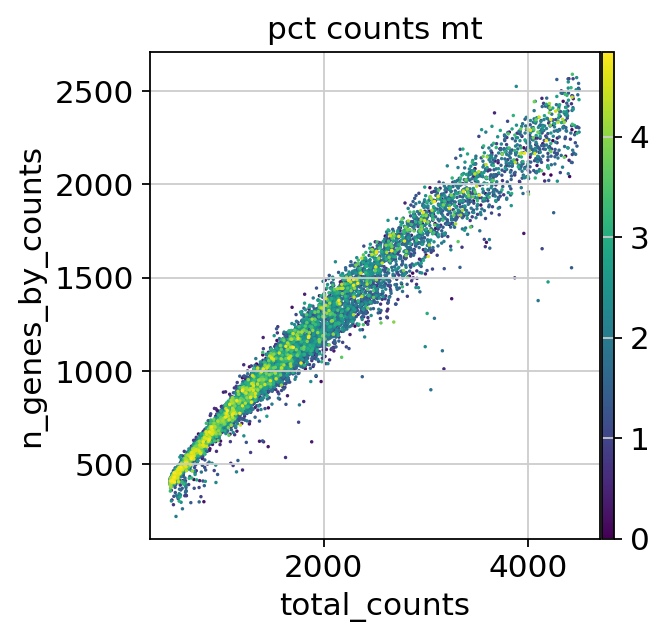

In [24]:
sc.pl.violin(adata, ["total_counts", "n_genes_by_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


**Defining MAD Function**

In [25]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

1. outlier based on 3 metrics (5 MADs)

Defined an outlier cell as one that is abnormal (too low or too high) in any of these 3 QC metrics:
log1p_total_counts → log-scaled total RNA per cell //
log1p_n_genes_by_counts → log-scaled number of detected genes //
pct_counts_in_top_20_genes → how dominated the cell is by a few highly expressed genes //
Threshold: A cell is flagged if its value is more than **5 MADs** away from the median (too low or too high)

In [26]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

/tmp/ipython-input-26-3478014923.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["outlier"] = (


,count
outlier,
False,12205
True,149


False → 12205 cells are **not outliers** (they passed the filter)

True  →   149 cells are **outliers** (they failed one or more of the 3 filters)


2.mt_outlier based on mitochondrial percentage

Defined a mitochondrial outlier in two ways:

If mitochondrial % is more than 3 MADs above the median.

OR if it is greater than 8%
This is a combined rule: a cell fails QC if it’s too extreme by MAD or by a strict upper cutoff of 8%.

In [28]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

,count
mt_outlier,
False,11635
True,719


False → 11,635 cells passed the mitochondrial QC

True  → 719 cells are mitochondrial outliers (and will be filtered)


**Removing Both Outliers**

In [30]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 12354
Number of cells after filtering of low quality cells: 11496


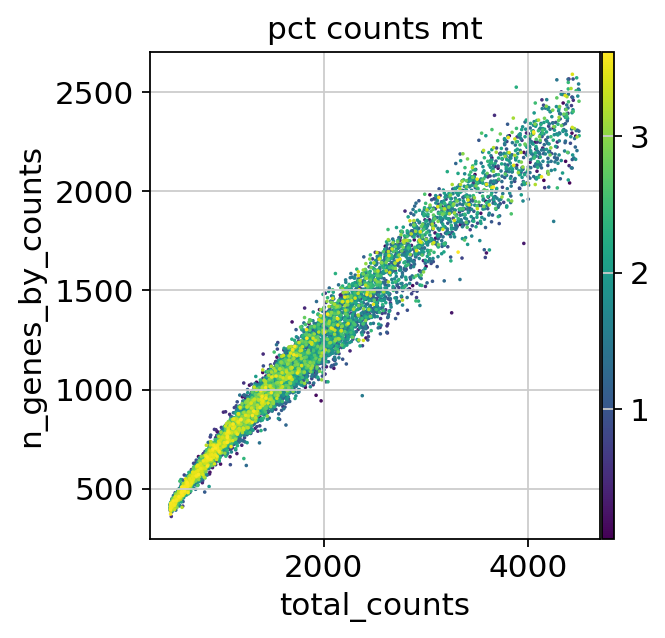

In [31]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# **What is Ambient RNA?
In droplet-based scRNA-seq, each droplet is supposed to contain:
One cell
Cell’s mRNA only
But in reality:
Some cells break open (lysis).
Their mRNA leaks into the solution.
This free-floating mRNA gets mixed into droplets — even empty ones
This leaked mRNA = ambient RNA, also called “the soup”**

**Why It’s a Problem**

Messes up downstream analysis (like clustering and cell-type identification)

Might lead to false discovery of gene expression

Can confuse true biology with technical artifacts

**The goal of ambient RNA correction is to:**

Detect and estimate background gene expression caused by cell-free mRNA

Subtract this contamination from the true signal

Make gene expression profiles more accurate

How SoupX Works — Step-by-Step (Simplified)

Let’s break it down into 3 simple stages:

✅ Step 1: Estimate the Soup Profile
SoupX first looks at empty droplets (those without real cells).
These droplets still have RNA from broken cells in the solution.
It builds an ambient RNA expression profile — a kind of fingerprint of the contamination.

🧠 Think of it like figuring out the flavor of the soup by sampling spoons that don’t have meat (real cells) — just the broth.

✅ Step 2: Estimate Contamination for Each Cell
Then, SoupX estimates how much of each cell’s RNA is contaminated.
It learns the fraction of gene counts that likely came from the soup.

📌 Each cell gets a contamination score (e.g., 5% of its RNA may be ambient contamination).

✅ Step 3: Correct the Expression Matrix
SoupX subtracts the estimated soup (background expression) from each cell's gene counts.

You get a corrected count matrix, where ambient RNA has been minimized or removed.